In [30]:
#load csv file into a pandas dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the data
df = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/quantex_at_home_data_sheet.xlsx')

df_age_group = df[["file name  (generated automatically)", "Age Group"]]
# remove the rows with missing values
df_age_group = df_age_group.dropna()

# Add .MP4 extension to file names
df_age_group["file name  (generated automatically)"] = df_age_group["file name  (generated automatically)"].astype(str) + ".MP4"

#store those two columns in a dictionary
age_group_dict = df_age_group.set_index("file name  (generated automatically)").to_dict()
age_group_dict = age_group_dict["Age Group"]

In [32]:
# Create table for age group mapping
cursor.execute("""
CREATE TABLE age_mapping (
    video_path TEXT,
    age_group INTEGER
)""")

# Insert age group mapping data into table
cursor.executemany("INSERT INTO age_mapping (video_path, age_group) VALUES (?, ?)", age_group_dict.items())
conn.commit()

In [40]:
# query sum of number of frames from all videos in database (total_frames column in VideoStatistics table)
# connect to sqlite database
import sqlite3
conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
c = conn.cursor()

# query sum of number of frames from all videos in database
c.execute('SELECT SUM(total_frames) FROM VideoStatistics')
total_frames = c.fetchone()[0]
total_frames

19023571

In [17]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
cursor = conn.cursor()

# Add new column (SQLite doesn't support ALTER TABLE ADD COLUMN IF NOT EXISTS)
try:
    cursor.execute("ALTER TABLE VideoStatistics ADD COLUMN age_group INTEGER")
    conn.commit()
except sqlite3.OperationalError:
    print("Column already exists, continuing...")

In [33]:
# Update videostatistics using the age_mapping table
update_query = """
UPDATE VideoStatistics 
SET age_group = (
    SELECT am.age_group
    FROM Videos v
    JOIN age_mapping am ON v.video_path = am.video_path
    WHERE v.video_id = VideoStatistics.video_id
)
"""
cursor.execute(update_query)
conn.commit()

In [ ]:
# Verify results
verification_query = """
SELECT 
    age_group,
    COUNT(*) as video_count,
    SUM(child_count) as total_child_count,
    SUM(adult_count) as total_adult_count,
    SUM(child_face_count) as total_child_face_count,
    SUM(adult_face_count) as total_adult_face_count,
    SUM(book_count) as total_book_count,
    SUM(toy_count) as total_toy_count,
    SUM(kitchenware_count) as total_kitchenware_count,
    SUM(screen_count) as total_screen_count,
    SUM(other_object_count) as total_other_object_count,
    SUM(total_frames) as total_frames
FROM VideoStatistics
GROUP BY age_group
ORDER BY age_group;
"""

results_df = pd.read_sql(verification_query, conn)
display(results_df)

,age_group,video_count,total_child_count,total_adult_count,total_child_face_count,total_adult_face_count,total_book_count,total_toy_count,total_kitchenware_count,total_screen_count,total_other_object_count,total_frames
0,NaN,3,1457,11437,536,2315,1912,4807,85,1009,1186,153449
1,3.0,141,171816,163315,57002,67018,14489,54486,6475,1599,54847,6288561
2,4.0,158,237325,164026,33123,61690,22000,39110,5986,10156,63975,6399674
3,5.0,151,90988,168925,33916,62980,31773,69201,5772,4338,69399,6181887


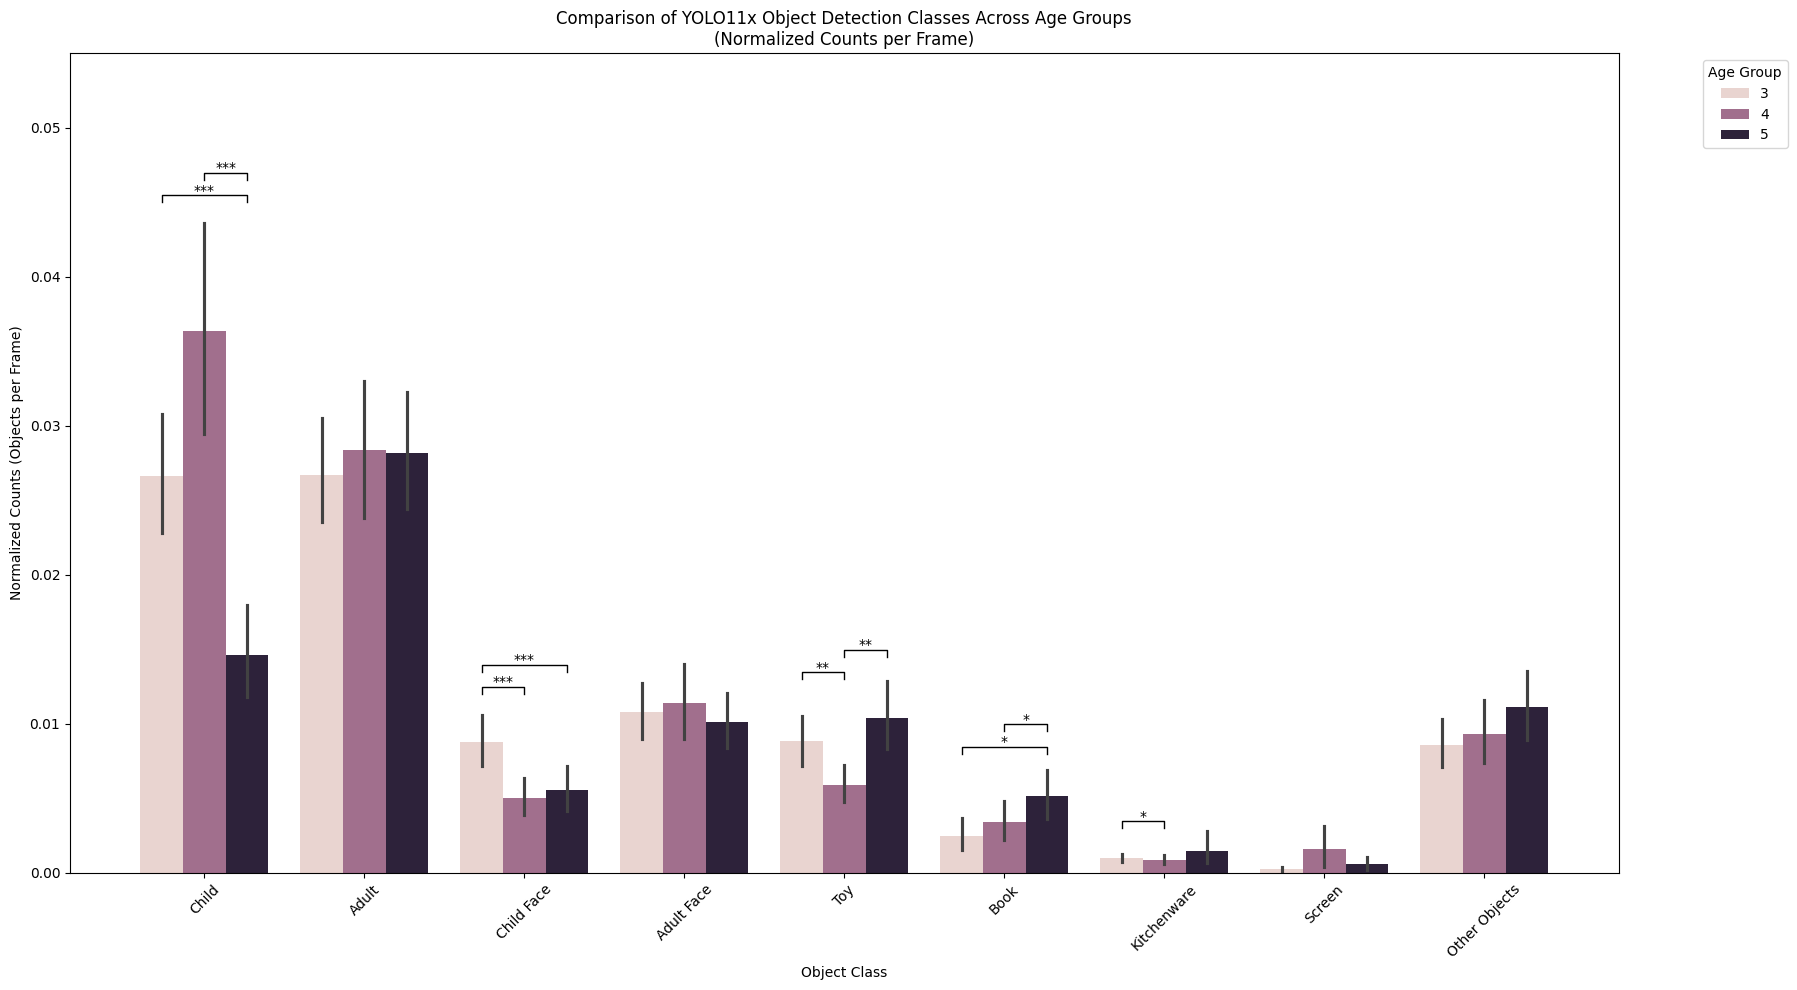

## Significant Kruskal-Wallis Results (p < 0.05) ##


,display_name,h_statistic,p_value
0,Child,37.0064,0.0000
2,Child Face,37.3937,0.0000
4,Toy,19.8125,0.0000
5,Book,14.1976,0.0008
6,Kitchenware,11.0704,0.0039
8,Other Objects,6.1005,0.0473



Raw Pairwise Comparisons:


,Class,Group 1,Group 2,p-value
0,Child,3,4,0.6838
1,Child,3,5,0.0000
2,Child,4,5,0.0000
3,Child Face,3,4,0.0000
4,Child Face,3,5,0.0000
5,Child Face,4,5,0.6678
6,Toy,3,4,0.0002
7,Toy,3,5,0.8744
8,Toy,4,5,0.0001
9,Book,3,4,0.5290



## Significant Pairwise Comparisons (Bonferroni-corrected) ##


,Class,Group 1,Group 2,Statistic,p_adjusted,Significance
1,Child,3,5,14867.0000,0.0000,***
2,Child,4,5,15575.0000,0.0001,***
3,Child Face,3,4,15179.0000,0.0000,***
4,Child Face,3,5,14415.0000,0.0000,***
6,Toy,3,4,13915.5000,0.0035,**
8,Toy,4,5,8849.5000,0.0016,**
10,Book,3,5,8389.5000,0.0316,*
11,Book,4,5,9317.5000,0.0156,*
12,Kitchenware,3,4,13505.0000,0.0261,*


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

# First, get raw data with proper summed normalization
raw_data_query = """
SELECT 
    age_group,
    video_id,
    CAST(child_count AS FLOAT) / total_frames as norm_child_count,
    CAST(adult_count AS FLOAT) / total_frames as norm_adult_count,
    CAST(child_face_count AS FLOAT) / total_frames as norm_child_face_count,
    CAST(adult_face_count AS FLOAT) / total_frames as norm_adult_face_count,
    CAST(toy_count AS FLOAT) / total_frames as norm_toy_count,
    CAST(book_count AS FLOAT) / total_frames as norm_book_count,
    CAST(kitchenware_count AS FLOAT) / total_frames as norm_kitchenware_count,
    CAST(screen_count AS FLOAT) / total_frames as norm_screen_count,
    CAST(other_object_count AS FLOAT) / total_frames as norm_other_object_count
FROM VideoStatistics
WHERE age_group IS NOT NULL;
"""

raw_data = pd.read_sql(raw_data_query, conn)

# Define classes and display names
classes = ['norm_child_count', 'norm_adult_count', 'norm_child_face_count',
           'norm_adult_face_count', 'norm_toy_count', 'norm_book_count',
           'norm_kitchenware_count', 'norm_screen_count', 'norm_other_object_count']

class_display_names = {
    'norm_child_count': 'Child',
    'norm_adult_count': 'Adult',
    'norm_child_face_count': 'Child Face',
    'norm_adult_face_count': 'Adult Face',
    'norm_toy_count': 'Toy',
    'norm_book_count': 'Book',
    'norm_kitchenware_count': 'Kitchenware',
    'norm_screen_count': 'Screen',
    'norm_other_object_count': 'Other Objects'
}

# Perform Kruskal-Wallis tests and track significant classes
test_results = []
significant_classes = []

for class_name in classes:
    groups = [group[class_name].values 
             for name, group in raw_data.groupby('age_group')]
    h_stat, p_val = stats.kruskal(*groups)
    
    test_results.append({
        'class_name': class_name,
        'display_name': class_display_names[class_name],
        'h_statistic': h_stat,
        'p_value': p_val
    })
    
    if p_val < 0.05:
        significant_classes.append(class_name)

significance_results = pd.DataFrame(test_results)

# Perform pairwise tests only for significant classes with Bonferroni correction
def perform_pairwise_tests(data, class_name, display_name):
    age_groups = sorted(data['age_group'].unique())
    results = []
    
    for i in range(len(age_groups)):
        for j in range(i+1, len(age_groups)):  
            group1 = data[data['age_group'] == age_groups[i]][class_name]
            group2 = data[data['age_group'] == age_groups[j]][class_name]
            
            stat, pval = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            results.append({
                'Class': display_name,
                'Group 1': age_groups[i],
                'Group 2': age_groups[j],
                'Statistic': stat,
                'p-value': pval
            })
    
    return results

# Collect and correct pairwise results
all_pairwise_results = []
for class_name in significant_classes:
    display_name = class_display_names[class_name]
    results = perform_pairwise_tests(raw_data, class_name, display_name)
    all_pairwise_results.extend(results)

pairwise_results_df = pd.DataFrame(all_pairwise_results)

# Apply Bonferroni correction
pairwise_results_df['p_adjusted'] = multipletests(
    pairwise_results_df['p-value'], method='bonferroni'
)[1]

# Add significance labels
pairwise_results_df['Significance'] = np.where(
    pairwise_results_df['p_adjusted'] < 0.001, '***',
    np.where(pairwise_results_df['p_adjusted'] < 0.01, '**',
    np.where(pairwise_results_df['p_adjusted'] < 0.05, '*', 'ns'))
)

# Prepare melted data for plotting
normalized_results_melted = pd.melt(
    raw_data,
    id_vars=['age_group'],
    value_vars=[c for c in classes],
    var_name='class',
    value_name='normalized_count'
)
normalized_results_melted['display_name'] = normalized_results_melted['class'].map(class_display_names)

# Create annotation dictionary from significant pairwise results
sig_pairwise = pairwise_results_df[pairwise_results_df['Significance'] != 'ns']
annotation_dict = {}
for _, row in sig_pairwise.iterrows():
    key = (row['Class'], row['Group 1'], row['Group 2'])
    annotation_dict[key] = row['Significance']

# Create visualization with significance bars
plt.figure(figsize=(18, 10))
ax = sns.barplot(
    x='display_name',
    y='normalized_count',
    hue='age_group',
    data=normalized_results_melted,
    order=class_display_names.values()
)

# Set fixed y-axis limit to 0.04
y_max_fixed = 0.055
ax.set_ylim(0, y_max_fixed)

# Define class-specific base heights
class_base_heights = {
    'Child': 0.045,         
    'Adult': 0.04,         
    'Child Face': 0.012,   
    'Adult Face': 0.04,    
    'Toy': 0.013,          
    'Book': 0.008,         
    'Kitchenware': 0.003,  
    'Screen': 0.04,      
    'Other Objects': 0.04
}

# Define spacing parameters
bracket_step = 0.0015  # Space between stacked brackets

# Track current height for each class to avoid overlaps
class_heights = {class_name: base_height for class_name, base_height in class_base_heights.items()}

# Get x positions for each category
x_positions = np.arange(len(class_display_names))
bar_width = 0.8 / len(raw_data['age_group'].unique())

# Loop through significant comparisons and draw brackets
for i, class_name in enumerate(class_display_names.values()):
    for j in range(len(age_groups)):
        for k in range(j+1, len(age_groups)):
            group1 = age_groups[j]
            group2 = age_groups[k]
            
            if (class_name, group1, group2) in annotation_dict:
                significance = annotation_dict[(class_name, group1, group2)]
                
                # Calculate x positions for bars
                x_pos1 = x_positions[i] + (j - len(age_groups)/2 + 0.5) * bar_width
                x_pos2 = x_positions[i] + (k - len(age_groups)/2 + 0.5) * bar_width
                
                # Get the current height for this class and increment for next
                y_pos = class_heights[class_name]
                class_heights[class_name] += bracket_step
                
                # Draw the bracket
                ax.plot([x_pos1, x_pos1, x_pos2, x_pos2], 
                        [y_pos, y_pos + bracket_step * 0.3, y_pos + bracket_step * 0.3, y_pos], 
                        color='black', linewidth=1)
                
                # Add the significance label
                ax.text((x_pos1 + x_pos2) / 2, y_pos + bracket_step * 0.2, significance, 
                       ha='center', va='bottom')

plt.title('Comparison of YOLO11x Object Detection Classes Across Age Groups\n(Normalized Counts per Frame)')
plt.xlabel('Object Class')
plt.ylabel('Normalized Counts (Objects per Frame)')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/quantex_normalized_counts.png')

plt.show()
# save the figure

# Display filtered results
print("## Significant Kruskal-Wallis Results (p < 0.05) ##")
display(significance_results[significance_results['p_value'] < 0.05]
        [['display_name', 'h_statistic', 'p_value']].round(4))

print("\nRaw Pairwise Comparisons:")
# display full p-values for as 0.0000
pd.options.display.float_format = '{:.4f}'.format
display(pairwise_results_df[['Class', 'Group 1', 'Group 2', 'p-value']])

print("\n## Significant Pairwise Comparisons (Bonferroni-corrected) ##")
display(sig_pairwise[['Class', 'Group 1', 'Group 2', 
                     'Statistic', 'p_adjusted', 'Significance']].round(4))


In [ ]:
# Close connection
conn.close()